In [2]:
import pandas as pd
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# Dataset Exploration and Modification

In [3]:
# read in us-city-place-names.csv and modify input so that the list only contains 
# unique lowercase city names
cityname_csv = pd.read_csv('us-city-place-names.csv')
citynames = cityname_csv['city'].tolist()
citynames = [d.lower().strip() for d in citynames]
random.shuffle(citynames)
citynames[:5]

['lincolnville center',
 'carrier mills village',
 'rockaway park',
 'uniondale',
 'junedale']

In [4]:
len(citynames) # number of city names

24375

In [5]:
chars = sorted(list(set(''.join(citynames)))) # sort letter alphabetically with no repeating letters
stoi = {s:i+1 for i, s in enumerate(chars)} # create a mapping of chars to integers
stoi['.'] = 0 # add special start and end character

itos = {i:s for s,i in stoi.items()} # create a integer to char mapping

print("stoi: ",  stoi)
print("itos: ", itos)

stoi:  {' ': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, '.': 0}
itos:  {1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}


# Multi-Layer Perceptron (MLP) Implementation

In [6]:
# create the dataset

block_size = 3 # characters needed to predict one
X, Y = [], [] # initialize input and label arrays

for c in citynames:
    context = [0] * block_size # create context 'window'
    for char in c + '.':
        idx = stoi[char] # get current character index
        
        X.append(context) # add current context to inputs
        Y.append(idx) # add current index to label
        context = context[1:] + [idx] # slide context 'window'
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([280236, 3]), torch.int64, torch.Size([280236]), torch.int64)

In [8]:
g = torch.Generator().manual_seed(42) # create a generator object for reproducability

C = torch.randn((28,2), generator=g) # create a lookup table

W1 = torch.randn((6,100), generator=g) # first weights matrix (6 inputs, 100 outputs)
b1 = torch.randn(100, generator=g) # first bias

W2 = torch.randn((100,28), generator=g) # second weights matrix (100 inputs, 28 outputs)
b2 = torch.randn(28, generator=g) # second bias

params = [C,W1,b1,W2,b2]
print("# of parameters: ", sum(p.nelement() for p in params))

# of parameters:  3584


In [9]:
for p in params:
    p.requires_grad = True

In [10]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [11]:
lri = []
lossi = []
for i in range(10000):
    
    # create mini-batch
    idx = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[idx]] # create embeddings of shape (32, 3, 2)

    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # output of first layer of shape (32, 100)
    logits = h @ W2 + b2 # output of second layer of shape (32, 28)

    loss = F.cross_entropy(logits, Y[idx]) # use cross entropy as loss function
    #print(loss.item())    

    # backward pass
    for p in params:
        p.grad = None

    loss.backward()
    
    # update
    # lr = lrs[i]
    lr = 10**-1.5
    for p in params:
        p.data +=  -lr * p.grad
        
    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())

#print(loss.item())

In [12]:
# forward pass
emb = C[X] # create embeddings on entire set

h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # output of first layer of shape (35, 100)
logits = h @ W2 + b2 # output of second layer of shape (35, 28)

loss = F.cross_entropy(logits, Y) # use cross entropy as loss function
loss.item()

2.3863234519958496

# Dataset Splitting and Model Training

In [13]:
# dataset splitting into train(80%), dev/validation(10%), test(10%)
# train is used to train parameters
# dev/validation is used to train hyperparameters
# test is used to evaluate the model
train, dev, test = torch.utils.data.random_split(citynames, [0.8, 0.1, 0.1], generator=g)

block_size = 3
vocab_size = len(stoi)

# function to create inputs and outputs from dataset
def build_dataset(dataset):
    X, Y = [], []
    for d in dataset:
        context = [0] * block_size # create context 'window'
        for char in d + '.':
            idx = stoi[char] # get current character index

            X.append(context) # add current context to inputs
            Y.append(idx) # add current index to label
            context = context[1:] + [idx] # slide context 'window'
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y
    

# defining training inputs and labels
Xtr, Ytr = build_dataset(train)
print("TRAIN: ", Xtr.shape, Ytr.shape)

# defining validation inputs and labels
Xdev, Ydev = build_dataset(dev)
print("DEV: ", Xdev.shape, Ydev.shape)

# defining test inputs and labels
Xte, Yte = build_dataset(test)
print("TEST: ", Xte.shape, Yte.shape)

TRAIN:  torch.Size([223995, 3]) torch.Size([223995])
DEV:  torch.Size([28372, 3]) torch.Size([28372])
TEST:  torch.Size([27869, 3]) torch.Size([27869])


In [14]:
n_embed = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in hidden layer

g = torch.Generator().manual_seed(42) # create a generator object for reproducability

C = torch.randn((vocab_size, n_embed),             generator=g) # create a lookup table

W1 = torch.randn((n_embed * block_size ,n_hidden), generator=g) # first weights matrix
b1 = torch.randn(n_hidden,                         generator=g) # first bias

W2 = torch.randn((n_hidden, vocab_size),           generator=g) # second weights matrix
b2 = torch.randn(vocab_size,                       generator=g) # second bias

params = [C,W1,b1,W2,b2]
print("# of parameters: ", sum(p.nelement() for p in params))
for p in params:
    p.requires_grad = True

# of parameters:  12108


In [15]:
batch_size = 32
max_steps=200000
lossi=[]

for i in range(max_steps):
    
    # create mini-batch
    idx = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[idx], Ytr[idx]
    
    # forward pass
    emb = C[Xb] # create embedding of characters into vectors
    emb_concat = emb.view(emb.shape[0], -1) # concetenate vectors

    h_preactivation = emb_concat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(h_preactivation) # hidden layer
    logits = h @ W2 + b2 # output layer
    
    loss = F.cross_entropy(logits, Yb) # use cross entropy as loss function

    # backward pass
    for p in params:
        p.grad = None

    loss.backward()
    
    # update
    lr= 0.1 if i < (150000) else 0.01
    for p in params:
        p.data +=  -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i}/{max_steps}: {loss.item():.4f}')
        
    lossi.append(loss.log10().item())

0/200000: 28.1557
10000/200000: 2.3238
20000/200000: 2.2586
30000/200000: 2.6418
40000/200000: 1.8982
50000/200000: 2.1581
60000/200000: 2.0424
70000/200000: 1.8936
80000/200000: 1.5423
90000/200000: 2.0338
100000/200000: 1.5305
110000/200000: 1.8967
120000/200000: 2.3637
130000/200000: 2.1613
140000/200000: 1.4209
150000/200000: 2.0705
160000/200000: 1.6410
170000/200000: 1.9048
180000/200000: 1.8682
190000/200000: 2.0464


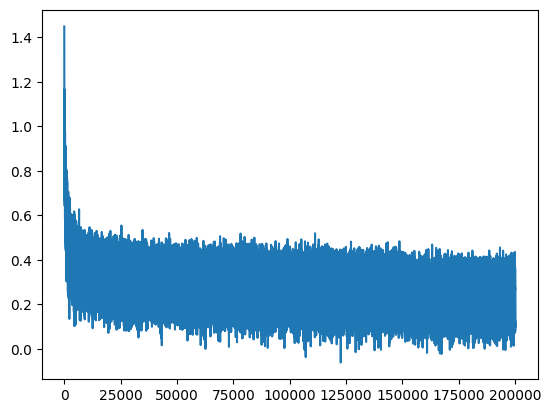

In [16]:
plt.plot(lossi)

In [17]:
emb = C[Xtr] # create embedding of characters into vectors
emb_concat = emb.view(emb.shape[0], -1) # concetenate vectors

h_preact = emb_concat @ W1 + b1 # hidden layer pre-activation
h = torch.tanh(h_preact) # hidden layer
logits = h @ W2 + b2 # output layer

loss = F.cross_entropy(logits, Ytr) # use cross entropy as loss function
print(f'Train loss: {loss.item()}')


emb = C[Xdev] # create embedding of characters into vectors
emb_concat = emb.view(emb.shape[0], -1) # concetenate vectors

h_preact = emb_concat @ W1 + b1 # hidden layer pre-activation
h = torch.tanh(h_preact) # hidden layer
logits = h @ W2 + b2 # output layer

loss = F.cross_entropy(logits, Ydev) # use cross entropy as loss function
print(f'Dev loss: {loss.item()}')

Train loss: 1.7813494205474854
Dev loss: 1.8124439716339111


In [18]:
# sample from model
for _ in range(5):
    out = [] # output array
    context = [0] * block_size # context 'window'
    
    while True:
        emb = C[torch.tensor([context])] # get embeddings from context and lookup table
        
        h = torch.tanh(emb.view(1,-1) @ W1 + b1) # first layer: tanh
        logits = h @ W2 + b2 # second layer: linear
        probs = F.softmax(logits, dim=1) # softmax to get probabilites
        
        idx = torch.multinomial(probs, num_samples=1, generator=g).item() # get next predicted letter
        context = context[1:] + [idx] # slide the context 'window'
        out.append(idx) # append the new letter to the output
        
        # if the character is '.' then end the word
        if idx == 0:
            break
    
    print(''.join(itos[i] for i in out))

tatie.
lon.
her.
sprisheer islanco.
granch.


# Tuning the Model

In [19]:
n_embed = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in hidden layer

g = torch.Generator().manual_seed(42 + 0) # create a generator object for reproducability

C = torch.randn((vocab_size, n_embed),             generator=g) # create a lookup table

W1 = torch.randn((n_embed * block_size ,n_hidden), generator=g) * (5/3) / ((n_embed * block_size)**0.5) # first weights matrix
# b1 = torch.randn(n_hidden,                         generator=g) * 0.01 # first bias

W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01 # second weights matrix
# b2 = torch.randn(vocab_size,                       generator=g) * 0 # second bias

batchn_gain = torch.ones((1,n_hidden))
batchn_bias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

# params = [C,W1,b1,W2,b2,batchn_gain, batchn_bias]
params = [C, W1, W2, b2, batchn_gain, batchn_bias]

print("# of parameters: ", sum(p.nelement() for p in params))
for p in params:
    p.requires_grad = True

# of parameters:  12308


In [20]:
batch_size = 32
max_steps=200000
lossi=[]

for i in range(max_steps):
    
    # create mini-batch
    idx = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[idx], Ytr[idx]
    
    # forward pass
    emb = C[Xb] # create embedding of characters into vectors
    emb_concat = emb.view(emb.shape[0], -1) # concetenate vectors

    # linear layer
    h_preact = emb_concat @ W1 # + b1 # hidden layer pre-activation
    
    # batch normalization layer
    batchn_meani = h_preact.mean(0, keepdims=True) 
    batchn_stdi = h_preact.std(0, keepdims=True)
    h_preact = batchn_gain * (h_preact - batchn_meani) / batchn_stdi + batchn_bias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * batchn_meani
        bnstd_running = 0.999 * bnstd_running + 0.001 * batchn_stdi
        
    # non-linear activation function
    h = torch.tanh(h_preact) # hidden layer
    logits = h @ W2 + b2 # output layer
    
    loss = F.cross_entropy(logits, Yb) # use cross entropy as loss function

    # backward pass
    for p in params:
        p.grad = None

    loss.backward()
    
    # update
    lr=0.1 if i < (150000) else 0.01
    for p in params:
        p.data +=  -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i}/{max_steps}: {loss.item():.4f}')
        
    lossi.append(loss.log10().item())

0/200000: 4.1832
10000/200000: 1.9546
20000/200000: 1.7517
30000/200000: 2.2955
40000/200000: 1.6762
50000/200000: 2.3262
60000/200000: 2.0660
70000/200000: 1.4319
80000/200000: 2.0401
90000/200000: 2.3223
100000/200000: 2.1884
110000/200000: 1.7262
120000/200000: 1.8796
130000/200000: 2.3127
140000/200000: 1.8296
150000/200000: 1.6520
160000/200000: 1.3387
170000/200000: 1.9606
180000/200000: 2.1560
190000/200000: 1.9024


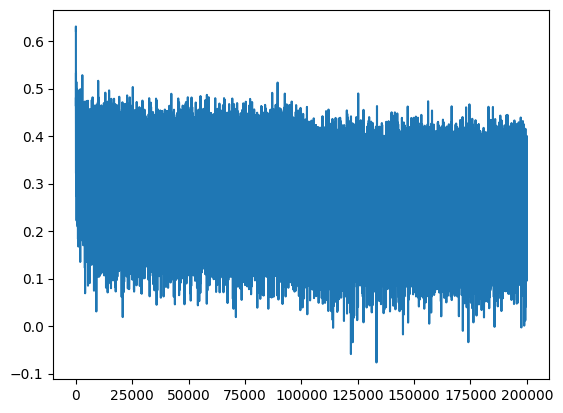

In [21]:
plt.plot(lossi)

In [22]:
@torch.no_grad()
def dataset_loss(dataset):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[dataset]
    
    emb = C[x] # create embedding of characters into vectors
    emb_concat = emb.view(emb.shape[0], -1) # concetenate vectors

    h_preact = emb_concat @ W1 + b1 # hidden layer pre-activation
    h_preact = batchn_gain * (h_preact - bnmean_running) / bnstd_running + batchn_bias
    h = torch.tanh(h_preact) # hidden layer
    logits = h @ W2 + b2 # output layer

    loss = F.cross_entropy(logits, y) # use cross entropy as loss function
    print(f'{dataset} loss: {loss.item()}')

dataset_loss('train')
dataset_loss('dev')

train loss: 1.9157794713974
dev loss: 1.9307262897491455


In [23]:
# sample from model
for _ in range(5):
    out = [] # output array
    context = [0] * block_size # context 'window'
    
    while True:
        emb = C[torch.tensor([context])] # get embeddings from context and lookup table
        emb_concat = emb.view(1,-1)
        
        h_preact = emb_concat @ W1 + b1 # hidden layer pre-activation
        h_preact = batchn_gain * (h_preact - bnmean_running) / bnstd_running + batchn_bias
        h = torch.tanh(h_preact) # hidden layer
        logits = h @ W2 + b2 # output layer
        probs = F.softmax(logits, dim=1) # softmax to get probabilites
        
        idx = torch.multinomial(probs, num_samples=1, generator=g).item() # get next predicted letter
        context = context[1:] + [idx] # slide the context 'window'
        out.append(idx) # append the new letter to the output
        
        # if the character is '.' then end the word
        if idx == 0:
            break
    
    print(''.join(itos[i] for i in out))

yart tragladroni ville.
hom.
grathfield.
shotphort tunzid.
porth heyvor.


### After further tuning, the dev loss dropped, and the resulting city names are even better! 

# PyTorch-ifying the Model

In [29]:
# linear layer
class Linear:
    
    # initialize weight and bias (if bias is set to True)
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # using kaiming normalization as base line
        self.bias = torch.zeros(fan_out) if bias else None
        
    # when module is called, Wx + b will occur
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    # function to return weight and bias tensors
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# 1 dimensional batch normalization layer
class BatchNorm1d:
    
    # initialize batch norm parameters
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # backprop parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers (running mean and std that trains with momentum)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    # when module is called, batch norm will occur
    def __call__(self, x):
        
        # if training then take the batch mean and variance
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
            
        # otherwise take the mean and variance over the whole dataset
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        # calculate normalization
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        
        # adjust normalization using gamma and beta
        self.out = self.gamma * xhat + self.beta
        
        # if training update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
                
        return self.out
    
    # get batch norm gain and bias
    def parameters(self):
        return [self.gamma, self.beta]
    
# non-linear tanh activation function
class Tanh:
    
    # when module is called, a tanh function will occur
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    # tanh has no parameters so none are returned
    def parameters(self):
        return []

In [51]:
g = torch.Generator().manual_seed(42) # for reproducibility

n_embed = 10 # dimensionality of character embedding vectors
n_hidden = 100 # number of neurons in hidden layer
block_size = 3 # characters needed to predict one

C = torch.randn((vocab_size, n_embed), generator=g) # create a lookup table

# layers of the MLP network
layers = [
    Linear(n_embed * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(            n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    
    # All other Linear layer wights are multiplied by a gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

# get all parameters (double list comprehension)
parameters = [C] + [p for layer in layers for p in layer.parameters()]

print(f'# of parameters: {sum(p.nelement() for p in parameters)}')
for p in parameters:
    p.requires_grad = True

# of parameters: 47664


In [52]:
batch_size = 32
max_steps=200000
lossi=[]
updata = []
for i in range(max_steps):
    
    # create mini-batch
    idx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[idx], Ytr[idx]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr=0.05 if i < (150000) else 0.005 # learning rate decay
    for p in parameters:
        p.data +=  -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i}/{max_steps}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        updata.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i > 10000:
        break

0/200000: 3.3401
10000/200000: 1.9994


Layer 2 (     Tanh): mean: -0.00 std: +0.64 saturated: 3.22%
Layer 5 (     Tanh): mean: +0.00 std: +0.65 saturated: 3.47%
Layer 8 (     Tanh): mean: +0.00 std: +0.65 saturated: 4.00%
Layer 11 (     Tanh): mean: -0.00 std: +0.66 saturated: 3.62%
Layer 14 (     Tanh): mean: +0.01 std: +0.67 saturated: 2.88%


Text(0.5, 1.0, 'Tanh Activation Distribution')

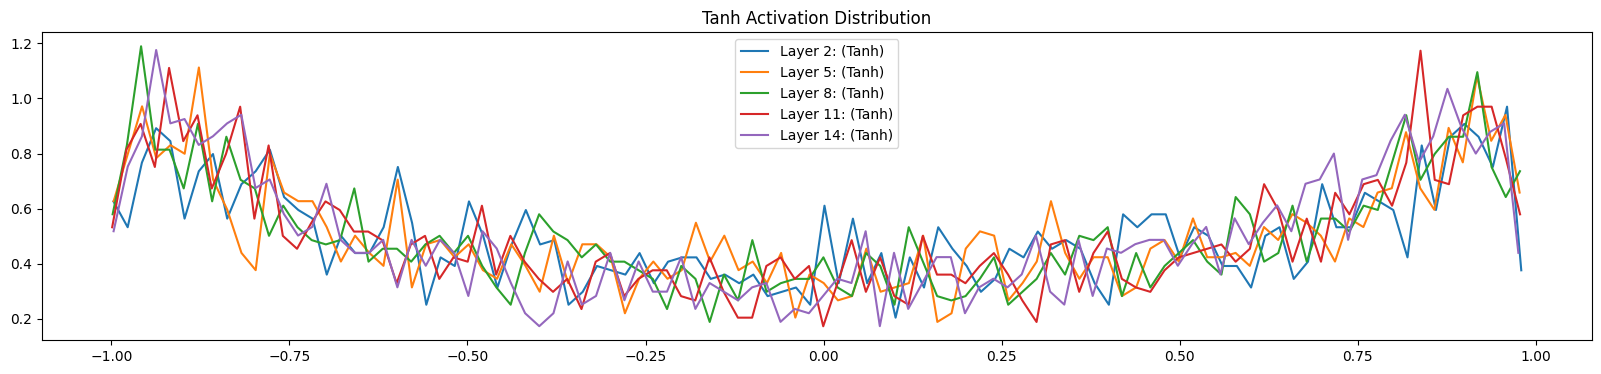

In [53]:
# show histograms
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'Layer {i:d} (     {layer.__class__.__name__}): mean: {t.mean():+.2f} std: {t.std():+.2f} saturated: {(t.abs() > 0.97).float().mean() * 100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i}: ({layer.__class__.__name__})')

plt.legend(legends);
plt.title("Tanh Activation Distribution")

Layer 2 (      Tanh) mean: -0.000000 std: 5.387925e-03
Layer 5 (      Tanh) mean: -0.000000 std: 4.964276e-03
Layer 8 (      Tanh) mean: +0.000000 std: 4.876792e-03
Layer 11 (      Tanh) mean: -0.000000 std: 4.719435e-03
Layer 14 (      Tanh) mean: +0.000000 std: 4.662234e-03


Text(0.5, 1.0, 'Tanh Gradient Distribution')

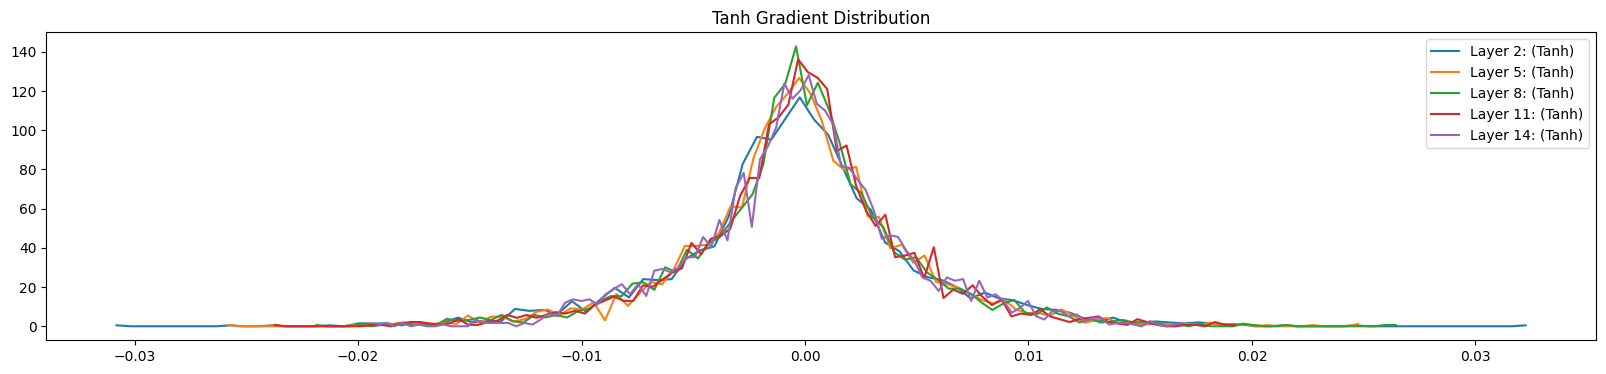

In [54]:
# show histograms
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'Layer {i} ({layer.__class__.__name__:>10s}) mean: {t.mean():+f} std: {t.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i}: ({layer.__class__.__name__})')

plt.legend(legends);
plt.title("Tanh Gradient Distribution")

weight:   (28, 10) | mean: -0.000000 | std: 1.370495e-02 | grad: data ratio 1.396047e-02
weight:  (30, 100) | mean: -0.000159 | std: 1.282596e-02 | grad: data ratio 4.148196e-02
weight: (100, 100) | mean: -0.000175 | std: 1.056350e-02 | grad: data ratio 6.051420e-02
weight: (100, 100) | mean: -0.000040 | std: 1.013347e-02 | grad: data ratio 5.802529e-02
weight: (100, 100) | mean: -0.000030 | std: 9.638856e-03 | grad: data ratio 5.542741e-02
weight: (100, 100) | mean: -0.000164 | std: 8.678108e-03 | grad: data ratio 4.970349e-02
weight:  (100, 28) | mean: +0.000227 | std: 1.581764e-02 | grad: data ratio 8.401351e-02


Text(0.5, 1.0, 'Weight Gradient Distribution')

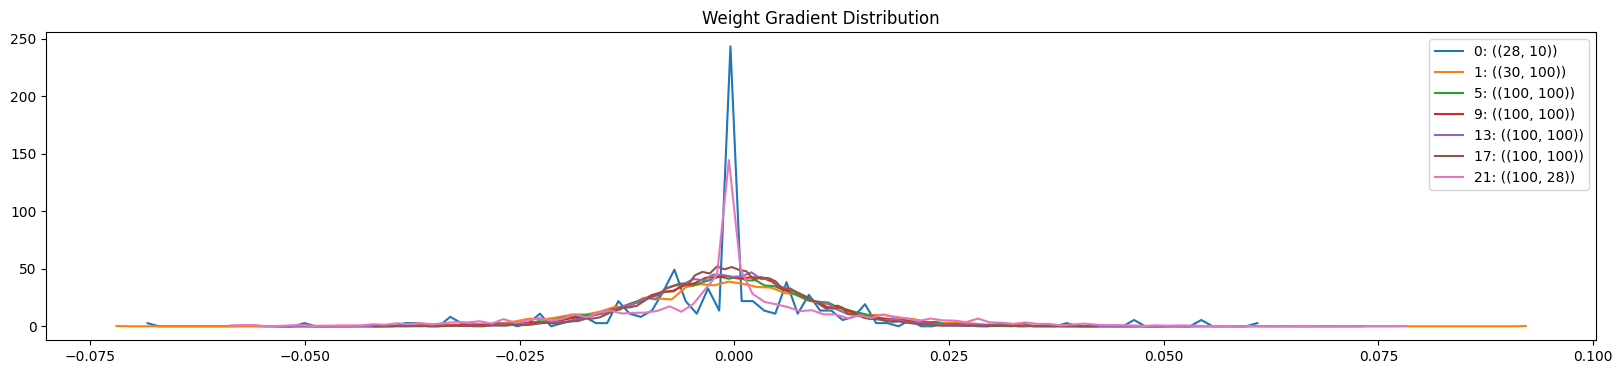

In [55]:
# show histograms
plt.figure(figsize=(20,4))
legends = []

for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(f'weight: {str(tuple(p.shape)):>10s} | mean: {t.mean():+f} | std: {t.std():e} | grad: data ratio {t.std() / p.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i}: ({tuple(p.shape)})')

plt.legend(legends);
plt.title("Weight Gradient Distribution")

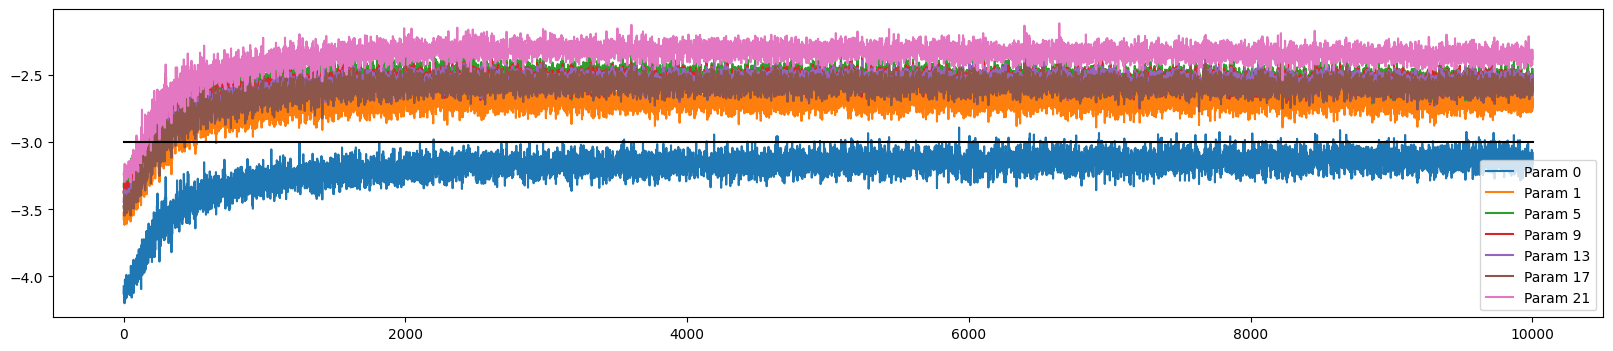

In [56]:
# show histograms
plt.figure(figsize=(20,4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([updata[j][i] for j in range(len(updata))])
        legends.append(f'Param {i}')

plt.plot([0,len(updata)], [-3,-3], 'k') # ratios should be ~1e-3
plt.legend(legends);